# 1. Простейший перцептрон

In [398]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import torch
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [327]:
def print_metrics(y_test, y_pred, model, target_names):
    print("Accuracy: %f" % accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    
    M = confusion_matrix(y_test, y_pred, labels=model.classes_)
    M_normalized = M.astype('float') / M.sum(axis=1)[:, np.newaxis]
    
    
    disp = ConfusionMatrixDisplay(confusion_matrix=M,
                                  display_labels=target_names)
    disp.plot(cmap='Greens')
    plt.xticks(ticks = range(len(target_names)), labels = target_names, rotation=90)
    plt.yticks(ticks = range(len(target_names)), labels = target_names)
    
    plt.ylabel('True digit')
    plt.xlabel('Predicted digit')
    plt.title('Confusion matrix')
    
    plt.show()

## Загружаем датасет ирисов

In [328]:
dataset = datasets.load_iris()

print(dataset.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [329]:
features = dataset.data
target = dataset.target

features.shape, target.shape

((150, 4), (150,))

In [330]:
X = pd.DataFrame(features, columns=dataset['feature_names'])
y = target
df = X.copy()
df['target'] = y

In [331]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [332]:
df.isnull().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
dtype: int64

## Визуализация данных

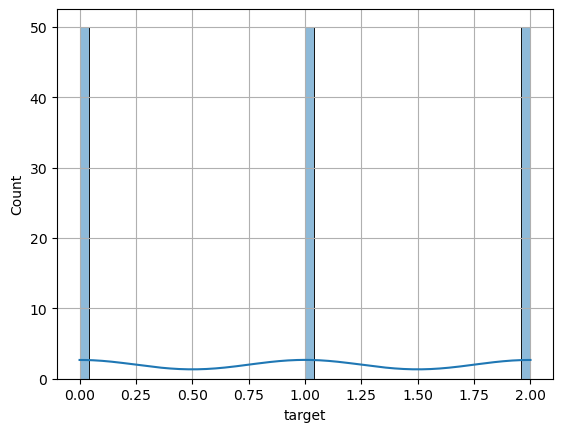

In [333]:
# посмотрим на распределение меток
sns.histplot(x='target', data=df, bins=50, kde=True)
plt.xlabel('target')
plt.grid()
plt.show()

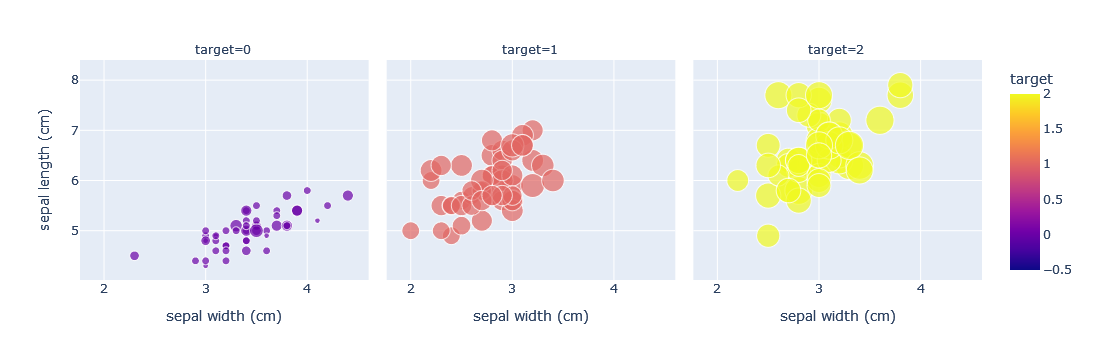

In [334]:
fig = px.scatter(df, x="sepal width (cm)", y="sepal length (cm)", color="target",
                 size='petal width (cm)', hover_data=['petal length (cm)'], facet_col="target")
fig.show()

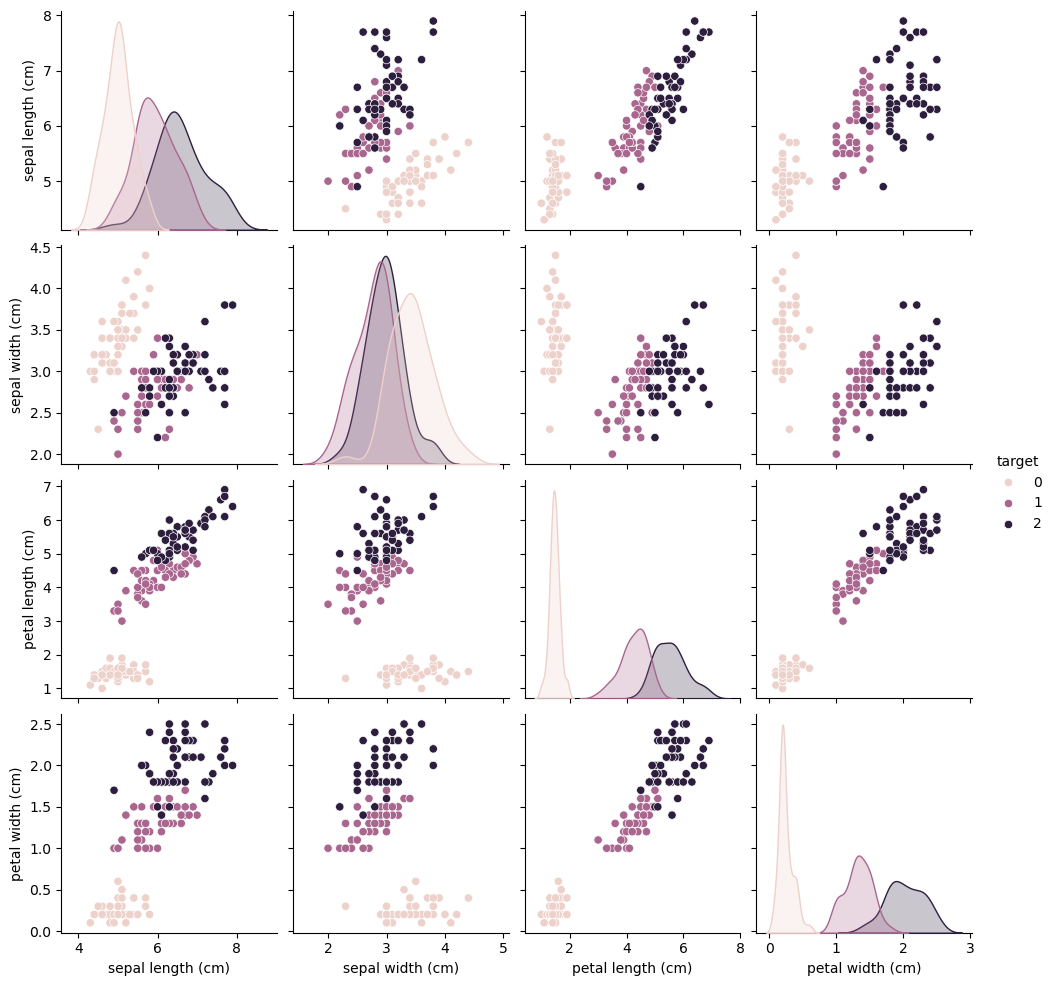

In [335]:
warnings.filterwarnings('ignore')

# нормальное распределение
sns.pairplot(data=df, hue='target')
plt.show()

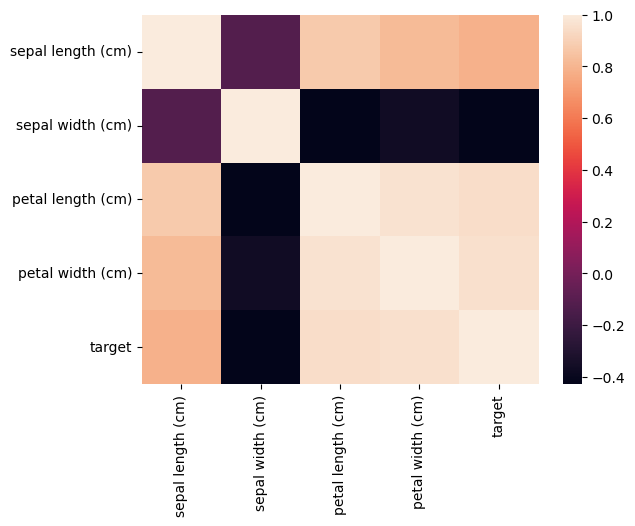

In [336]:
sns.heatmap(df.corr())
plt.show()

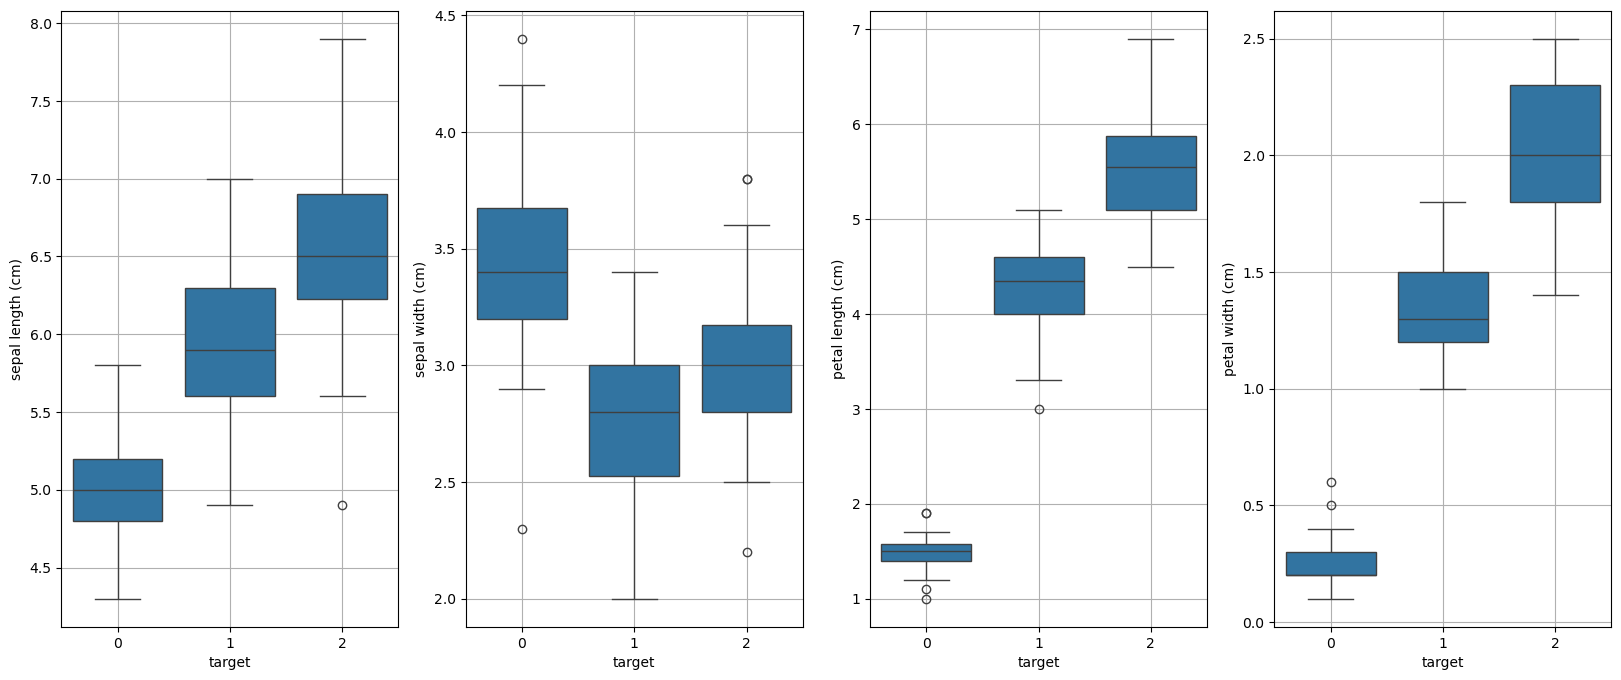

In [337]:
plt.figure(figsize=(20 , 8))

for i, col in enumerate(X.columns):
    plt.subplot(1, len(X.columns), i + 1)
    sns.boxplot(y=col, x='target', data=df)
    plt.grid()
    
plt.show()

## Возьмем два признака, которые наименее скоррелированы и два класса, которые хорошо разделимы

In [338]:
df_small = df[['sepal width (cm)', 'petal length (cm)', 'target']]
df_small = df_small[(df_small.target == 1) | (df_small.target == 2)]
target_names_small = ['sepal width (cm)', 'petal length (cm)']
df_small

,sepal width (cm),petal length (cm),target
50,3.2,4.7,1
51,3.2,4.5,1
52,3.1,4.9,1
53,2.3,4.0,1
54,2.8,4.6,1
...,...,...,...
145,3.0,5.2,2
146,2.5,5.0,2
147,3.0,5.2,2
148,3.4,5.4,2


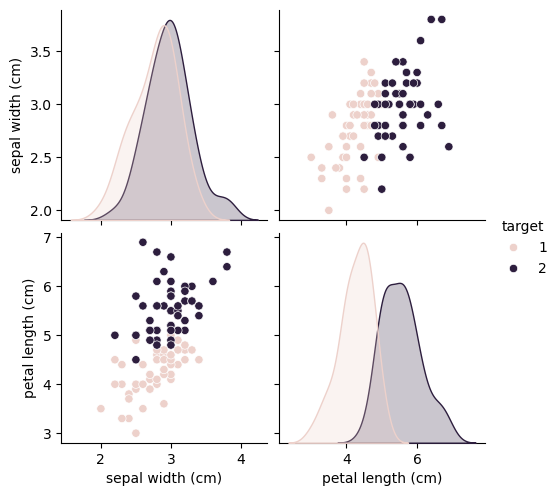

In [339]:
sns.pairplot(data=df_small, hue='target')
plt.show()

In [340]:
X = df_small[['sepal width (cm)', 'petal length (cm)']]
y = df_small['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

### SVC

In [341]:
param_grid = [
  {'C': [1, 5, 10], 'kernel': ['linear']},
  {'C': [1, 5, 10], 'gamma': ['scale'], 'kernel': ['rbf']},
  #{'C': [1, 5, 10], 'degree': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'gamma': ['scale'], 'kernel': ['poly']},
  #{'C': [0.1, 1, 5, 10], 'kernel': ['sigmoid']}
]
svc = SVC()
clf_svc = GridSearchCV(svc, param_grid)

clf_svc.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 5, 10], 'kernel': ['linear']},
                         {'C': [1, 5, 10], 'gamma': ['scale'],
                          'kernel': ['rbf']}])

In [342]:
print('Наилучшие гиперпараметры: ', clf_svc.best_params_)

Наилучшие гиперпараметры:  {'C': 5, 'kernel': 'linear'}


In [343]:
df_res = pd.DataFrame(clf_svc.cv_results_)[['mean_fit_time', 'params', 'mean_test_score']]
df_res[df_res.mean_test_score > 0.85]

,mean_fit_time,params,mean_test_score
0,0.000806,"{'C': 1, 'kernel': 'linear'}",0.9125
1,0.000796,"{'C': 5, 'kernel': 'linear'}",0.9375
2,0.000654,"{'C': 10, 'kernel': 'linear'}",0.9375
3,0.000601,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.9125
4,0.000800,"{'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}",0.9250
5,0.000400,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.9375


In [344]:
y_pred = clf_svc.predict(X_test)

Accuracy: 0.950000
                   precision    recall  f1-score   support

 sepal width (cm)       0.88      1.00      0.93         7
petal length (cm)       1.00      0.92      0.96        13

         accuracy                           0.95        20
        macro avg       0.94      0.96      0.95        20
     weighted avg       0.96      0.95      0.95        20



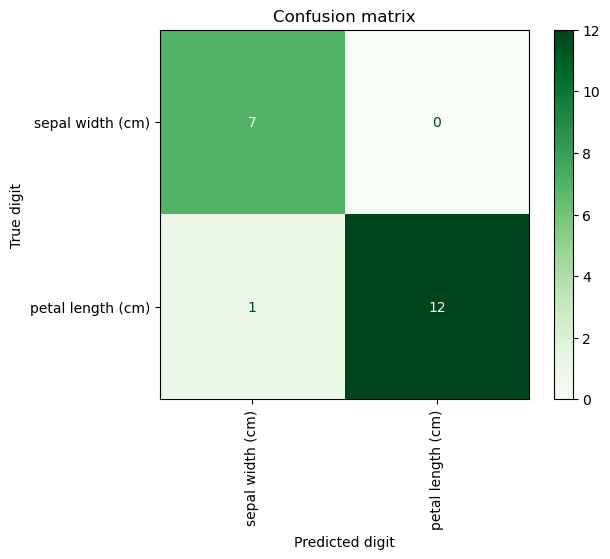

In [345]:
print_metrics(y_test, y_pred, clf_svc, target_names_small)

### Logistic Regression

In [346]:
param_grid = [
    {'C': [1, 5, 10], 'solver': ['liblinear'], 'multi_class': ['ovr'], 'penalty': ['l1', 'l2']},
    {'C': [1, 5, 10], 'solver': ['lbfgs'], 'multi_class': ['ovr', 'multinomial'], 'penalty': ['l1', 'none']},
    {'C': [1, 5, 10], 'solver': ['newton-cg'], 'multi_class': ['ovr', 'multinomial'], 'penalty': ['l1', 'none']},
    {'C': [1, 5, 10], 'solver': ['sag'], 'multi_class': ['ovr', 'multinomial'], 'penalty': ['l1', 'none']},
    {'C': [1, 5, 10], 'solver': ['saga'], 'multi_class': ['ovr', 'multinomial'], 'penalty': ['l1', 'l2', 'none']}
]

logistic_regression = LogisticRegression()
clf_lr = GridSearchCV(logistic_regression, param_grid)

clf_lr.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid=[{'C': [1, 5, 10], 'multi_class': ['ovr'],
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
                         {'C': [1, 5, 10],
                          'multi_class': ['ovr', 'multinomial'],
                          'penalty': ['l1', 'none'], 'solver': ['lbfgs']},
                         {'C': [1, 5, 10],
                          'multi_class': ['ovr', 'multinomial'],
                          'penalty': ['l1', 'none'], 'solver': ['newton-cg']},
                         {'C': [1, 5, 10],
                          'multi_class': ['ovr', 'multinomial'],
                          'penalty': ['l1', 'none'], 'solver': ['sag']},
                         {'C': [1, 5, 10],
                          'multi_class': ['ovr', 'multinomial'],
                          'penalty': ['l1', 'l2', 'none'],
                          'solver': ['saga']}])

In [347]:
print('Наилучшие гиперпараметры: ', clf_lr.best_params_)

Наилучшие гиперпараметры:  {'C': 5, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}


In [348]:
df_res = pd.DataFrame(clf_lr.cv_results_)[['mean_fit_time', 'params', 'mean_test_score']]
df_res[df_res.mean_test_score > 0.85]

,mean_fit_time,params,mean_test_score
0,0.002103,"{'C': 1, 'multi_class': 'ovr', 'penalty': 'l1'...",0.8875
1,0.000999,"{'C': 1, 'multi_class': 'ovr', 'penalty': 'l2'...",0.8750
2,0.001833,"{'C': 5, 'multi_class': 'ovr', 'penalty': 'l1'...",0.9125
3,0.000864,"{'C': 5, 'multi_class': 'ovr', 'penalty': 'l2'...",0.8875
4,0.001541,"{'C': 10, 'multi_class': 'ovr', 'penalty': 'l1...",0.9125
5,0.000772,"{'C': 10, 'multi_class': 'ovr', 'penalty': 'l2...",0.8875
42,0.001536,"{'C': 1, 'multi_class': 'ovr', 'penalty': 'l1'...",0.8875
43,0.001040,"{'C': 1, 'multi_class': 'ovr', 'penalty': 'l2'...",0.9125
45,0.001600,"{'C': 1, 'multi_class': 'multinomial', 'penalt...",0.9125
46,0.001889,"{'C': 1, 'multi_class': 'multinomial', 'penalt...",0.9125


In [349]:
y_pred = clf_svc.predict(X_test)

Accuracy: 0.950000
                   precision    recall  f1-score   support

 sepal width (cm)       0.88      1.00      0.93         7
petal length (cm)       1.00      0.92      0.96        13

         accuracy                           0.95        20
        macro avg       0.94      0.96      0.95        20
     weighted avg       0.96      0.95      0.95        20



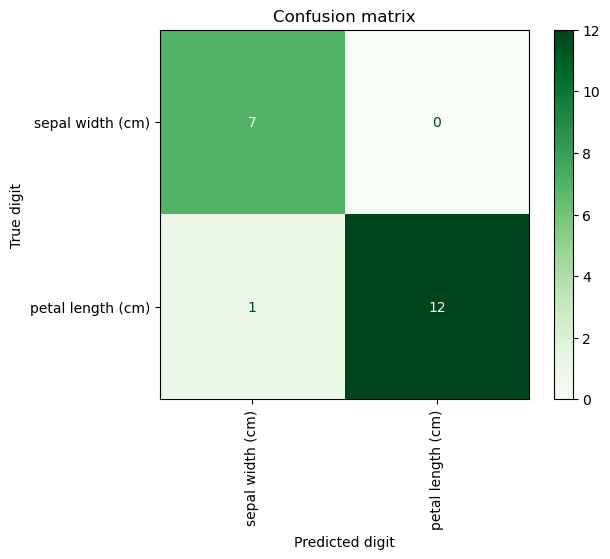

In [350]:
print_metrics(y_test, y_pred, clf_svc, target_names_small)

### Perceptron

In [356]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def deriv_sigmoid(x):
    fx = sigmoid(x)
    return fx * (1 - fx)

def mse_loss(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

class Perceptron:
    def __init__(self):
        a = 1 / np.sqrt(2)
        self.w1 = a * np.random.normal()
        self.w2 = a * np.random.normal()
        self.b = a * np.random.normal()

    def feedforward(self, input):
        output = sigmoid(self.w1 * input[0] + self.w2 * input[1] + self.b)
        return output

    def train(self, X_train, y_train):
        learning_rate = 1e-1
        epochs = 1000

        for epoch in range(epochs):
            for x, y_true in zip(X_train, y_train):
                # прямой проход
                sum_output = self.w1 * x[0] + self.w2 * x[1] + self.b
                output = sigmoid(sum_output)
                y_pred = output

                # считаем производные
                d_L_d_ypred = -2 * (y_true - y_pred)
                d_ypred_d_w1 = x[0] * deriv_sigmoid(sum_output)
                d_ypred_d_w2 = x[1] * deriv_sigmoid(sum_output)
                d_ypred_d_b = deriv_sigmoid(sum_output)

                # обновляем веса
                self.w1 -= learning_rate * d_L_d_ypred * d_ypred_d_w1
                self.w2 -= learning_rate * d_L_d_ypred * d_ypred_d_w2
                self.b -= learning_rate * d_L_d_ypred * d_ypred_d_b

            if epoch % 100 == 0:
                y_preds = np.apply_along_axis(self.feedforward, 1, X_train)
                loss = mse_loss(y_train, y_preds)
                print("Epoch %d loss: %.3f" % (epoch, loss))

    def predict(self, X_test):
        y_preds = np.apply_along_axis(self.feedforward, 1, X_test)
        y_preds = np.rint(y_preds).astype(np.int32)
        return y_preds

    def accuracy(self, y_true, y_pred):
        return y_pred[y_pred == y_true].shape[0] / y_true.shape[0]

In [357]:
y_train_modify = y_train.copy()
y_train_modify[y_train_modify == 1] = 0
y_train_modify[y_train_modify == 2] = 1

y_test_modify = y_test.copy()
y_test_modify[y_test_modify == 1] = 0
y_test_modify[y_test_modify == 2] = 1

In [358]:
network = Perceptron()
network.train(X_train, y_train_modify)

Epoch 0 loss: 0.447
Epoch 100 loss: 0.087
Epoch 200 loss: 0.080
Epoch 300 loss: 0.075
Epoch 400 loss: 0.070
Epoch 500 loss: 0.065
Epoch 600 loss: 0.062
Epoch 700 loss: 0.060
Epoch 800 loss: 0.058
Epoch 900 loss: 0.057


In [359]:
y_pred = network.predict(X_test)
y_pred, y_test_modify

(array([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0]),
 array([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0]))

In [360]:
network.accuracy(y_test_modify, y_pred)

0.95

# 2. Простейший многослойный перцептрон с датасетом Iris

In [266]:
X = df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']].to_numpy()
y = df['target'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [438]:
class Linear:

    def __init__(self, n_inputs, n_neurons):
        self.weights = np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)


class Activation_Sigmoid:

    def forward(self, inputs):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))

    def backward(self, dvalues):
        self.dinputs = dvalues * (1 - self.output) * self.output

    def predictions(self, outputs):
        return (outputs > 0.5) * 1


class Activation_ReLU:

    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

    def predictions(self, outputs):
        return outputs


class Activation_Softmax:

    def forward(self, inputs):
        self.inputs = inputs
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1, 1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)


class SGD:

    def __init__(self, learning_rate=1., decay=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0

    def update_params(self, layer):
        self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
        weight_updates = - self.current_learning_rate * layer.dweights
        bias_updates = - self.current_learning_rate * layer.dbiases

        layer.weights += weight_updates
        layer.biases += bias_updates

        self.iterations += 1


class Loss:

    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)

        return data_loss


class Loss_CategoricalCrossentropy(Loss):

    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)


        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]

        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    def backward(self, dvalues, y_true):
        samples = len(dvalues)

        self.dinputs = -y_true / dvalues # Calculate gradient
        self.dinputs = self.dinputs / samples # Normalize gradient


class Activation_Softmax_Loss_CategoricalCrossentropy():

    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        
        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true):

        samples = len(dvalues)

        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs / samples


class Model:

    def __init__(self):
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)

    def set(self, loss, optimizer):
        self.loss = loss
        self.optimizer = optimizer

    def train(self, X, y, epochs=1):
        for epoch in range(epochs + 1):
            output_cur = X
            for layer in self.layers:
                layer.forward(output_cur)
                output_cur = layer.output

            loss_score = self.loss.forward(output_cur, y)
            predictions = np.argmax(self.loss.output, axis=1)
            accuracy = np.mean(predictions==y)
        
            if not epoch % 25:
                print(f'epoch: {epoch}, ' +
                      f'accuracy: {accuracy:.3f}, ' +
                      f'loss_score: {loss_score:.3f}, ' +
                      f'lr: {self.optimizer.current_learning_rate}')

            self.loss.backward(self.loss.output, y)
            gradIn = self.loss.dinputs
            
            for layer in self.layers[::-1]:
                layer.backward(gradIn)
                gradIn = layer.dinputs
        
            for layer in self.layers:
                if type(layer) == type(Linear(1, 1)):
                    self.optimizer.update_params(layer)

    def predict(self, X_test):
        output_cur = X_test
        for layer in self.layers:
            layer.forward(output_cur)
            output_cur = layer.output

        self.loss.activation.forward(output_cur)
        predictions = np.argmax(self.loss.activation.output, axis=1)
        
        return predictions


    def accuracy(self, y_true, y_pred):
        return y_pred[y_pred == y_true].shape[0] / y_true.shape[0]

In [271]:
model = Model()

model.add(Linear(4, 4))
model.add(Activation_Sigmoid())
model.add(Linear(4, 3))

model.set(
    loss=Activation_Softmax_Loss_CategoricalCrossentropy(),
    optimizer=SGD(learning_rate=0.05, decay=1e-5),
)

model.train(X_train, y_train, epochs=5000)

epoch: 0, accuracy: 0.333, loss_score: 1.267, lr: 0.05
epoch: 25, accuracy: 0.333, loss_score: 1.007, lr: 0.049975511999120426
epoch: 50, accuracy: 0.667, loss_score: 0.917, lr: 0.04995054895653303
epoch: 75, accuracy: 0.667, loss_score: 0.869, lr: 0.04992561083984863
epoch: 100, accuracy: 0.667, loss_score: 0.832, lr: 0.049900697611752615
epoch: 125, accuracy: 0.667, loss_score: 0.801, lr: 0.049875809235004835
epoch: 150, accuracy: 0.675, loss_score: 0.773, lr: 0.04985094567243941
epoch: 175, accuracy: 0.683, loss_score: 0.749, lr: 0.0498261068869645
epoch: 200, accuracy: 0.692, loss_score: 0.726, lr: 0.04980129284156218
epoch: 225, accuracy: 0.692, loss_score: 0.707, lr: 0.049776503499288194
epoch: 250, accuracy: 0.692, loss_score: 0.689, lr: 0.04975173882327187
epoch: 275, accuracy: 0.692, loss_score: 0.672, lr: 0.04972699877671583
epoch: 300, accuracy: 0.692, loss_score: 0.656, lr: 0.04970228332289586
epoch: 325, accuracy: 0.692, loss_score: 0.641, lr: 0.049677592425160705
epoch: 3

In [272]:
y_pred = model.predict(X_test)

In [273]:
model.accuracy(y_test, y_pred)

0.9333333333333333

# 3. Простейший многослойный перцептрон с датасетом MNIST

In [423]:
import struct
def load_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [424]:
train_images_path = 'datasets/train-images.idx3-ubyte'
train_labels_path = 'datasets/train-labels.idx1-ubyte'
test_images_path = 'datasets/t10k-images.idx3-ubyte'
test_labels_path = 'datasets/t10k-labels.idx1-ubyte'

X_train = load_idx(train_images_path)
y_train = load_idx(train_labels_path)
X_test = load_idx(test_images_path)
y_test = load_idx(test_labels_path)

In [425]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

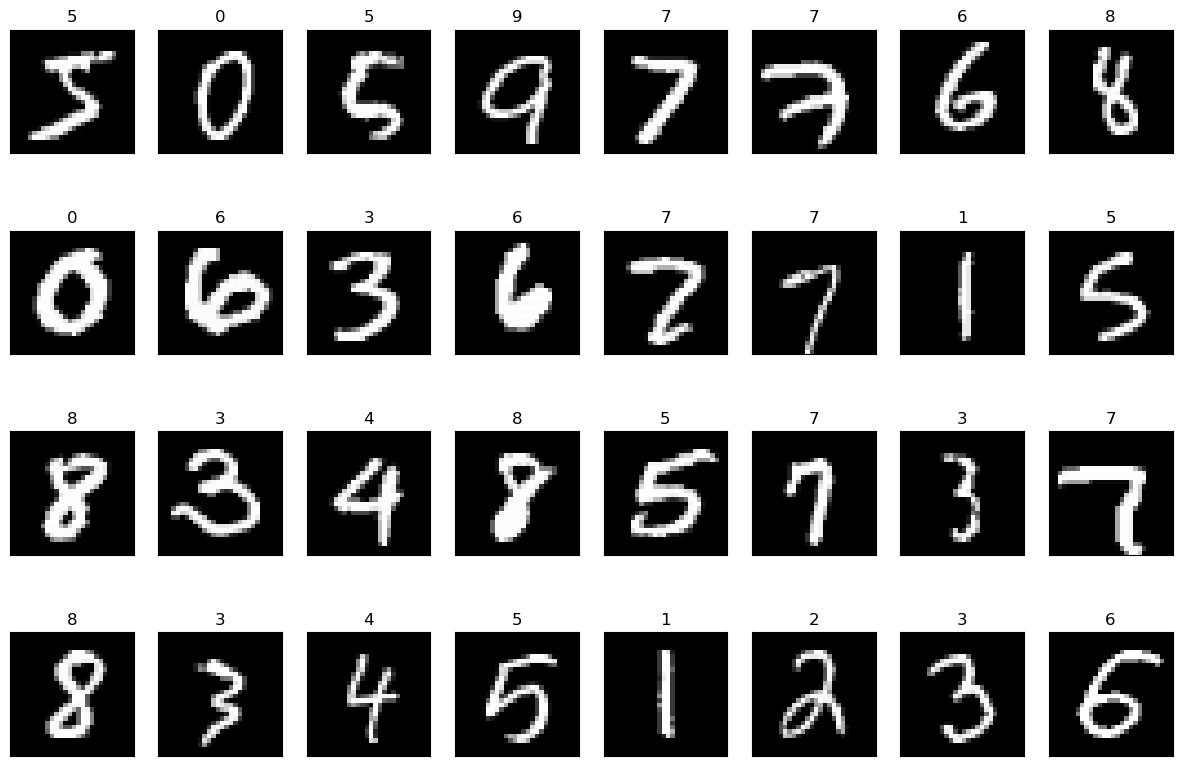

In [426]:
# Смотрим датасет

rows = 4
cols = 8
fig, ax = plt.subplots(rows, cols, figsize=(15, 10))

num = 0
for i in range(rows):
    for j in range(cols):
        ax[i][j].imshow(X_train[1000 * num], cmap = 'gray')
        ax[i][j].set_title(y_train[1000 * num])
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        num += 1

In [427]:
# Распрямляем массивы 

X_train = [image.flatten() for image in X_train]
X_test = [image.flatten() for image in X_test]

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
target_names=list(map(str, np.unique(y_test)))
X_train.shape, y_train

((60000, 784), array([5, 0, 4, ..., 5, 6, 8], dtype=uint8))

In [428]:
pca = PCA(n_components=100).fit(X_train)

In [429]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [430]:
X_train_pca.shape, y_train.shape, X_test_pca.shape

((60000, 100), (60000,), (10000, 100))

In [431]:
D_out = len(np.unique(y_train))
D_in = X_train_pca.shape[1]

In [442]:
%%time
model_mnist = Model()

model_mnist.add(Linear(D_in, 50))
model_mnist.add(Activation_Sigmoid())
model_mnist.add(Linear(50, D_out))

model_mnist.set(
    loss=Activation_Softmax_Loss_CategoricalCrossentropy(),
    optimizer=SGD(learning_rate=1e2, decay=1e-1),
)

model_mnist.train(X_train_pca, y_train, epochs=100)

epoch: 0, accuracy: 0.070, loss_score: 8.062, lr: 100.0
epoch: 25, accuracy: 0.811, loss_score: 2.140, lr: 16.94915254237288
epoch: 50, accuracy: 0.832, loss_score: 1.818, lr: 9.174311926605503
epoch: 75, accuracy: 0.839, loss_score: 1.685, lr: 6.289308176100629
epoch: 100, accuracy: 0.842, loss_score: 1.619, lr: 4.78468899521531
CPU times: total: 2min 19s
Wall time: 38 s


In [443]:
y_pred = model_mnist.predict(X_test_pca)

In [444]:
model_mnist.accuracy(y_test, y_pred)

0.8397

# 4. Pytorch

In [383]:
mean = X_train_pca.mean()
std = X_train_pca.std()

x_train_norm = ((X_train_pca - mean) / std)
x_test_norm = ((X_test_pca - mean) / std)

In [384]:
x_train_norm.shape, x_test_norm.shape

((60000, 100), (10000, 100))

In [389]:
x_train_norm.shape

(60000, 100)

In [390]:
def batch_train(model, optimizer, x, y):
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    model.zero_grad()
    loss.backward()
    optimizer.step()
    return (loss.item())

In [391]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)

In [392]:
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, 20),
    torch.nn.Sigmoid(),
    torch.nn.Linear(20, D_out),
    torch.nn.Softmax(dim=1)
)

In [393]:
model_he_SGD = model.apply(init_weights)

In [394]:
optimizerSGD = torch.optim.SGD(model_he_SGD.parameters(), lr=0.01, momentum=0.0)

In [400]:
n_epochs = 10
batch_size = 1000


loss_test_sgd = []

for epoch in range(n_epochs):

    permutation = torch.randperm(x_train_norm.shape[1])

    for i in tqdm(range(0,x_train_norm.shape[1], batch_size)):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train_norm[indices], y_train[indices]
        batch_train(model_he_SGD, optimizerSGD, batch_x, batch_y)
        batch_train(model_he_Momentum, optimizerMomentum, batch_x, batch_y)
        batch_train(model_he_Adam, optimizerAdam, batch_x, batch_y)

    y_test_pred = model_he_SGD(x_test_norm)
    loss_train = loss_fn(y_test_pred, y_test).detach().numpy()
    print(f' SGD Epoch: {epoch} loss {loss_train}')
    loss_test_sgd.append(loss_train)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


IndexError: index 82 is out of bounds for axis 0 with size 80

In [ ]:
fig = plt.figure(figsize=(16, 4))

plt.plot(loss_test_sgd, label='SGD')
plt.plot(loss_test_sgd_moment, label='SGD with momentum')
plt.plot(loss_test_adam, label='Adam')

plt.legend()
plt.show()

In [418]:
model = torch.nn.Sequential()
model.add_module("first", torch.nn.Linear(D_in, 20))
model.add_module("second", torch.nn.Sigmoid())
model.add_module("third", torch.nn.Linear(20, D_out))

opt = torch.optim.SGD(model.parameters(), lr=1e-3)

In [420]:
history = []
epochs = 1000

for i in range(epochs):
    ix = np.random.randint(0, len(X_train), 10000)
    x_batch = torch.tensor(X_train_pca[ix], dtype=torch.float32)
    y_batch = torch.tensor(y_train[ix], dtype=torch.float32)

    y_predicted = model(x_batch)[:, 0]
    CE = torch.nn.CrossEntropyLoss()
    loss = CE(y_predicted, y_batch)
    
    loss.backward()
    opt.step()
    opt.zero_grad()

    history.append(loss.data.numpy())

    if i % 10 == 0:
        print("step #%i | mean loss = %.3f" % (i, np.mean(history[-10:])))

step #0 | mean loss = 133649.188
step #10 | mean loss = 395206.469
step #20 | mean loss = 541582.000
step #30 | mean loss = 536236.000
step #40 | mean loss = 530669.312
step #50 | mean loss = 510453.250
step #60 | mean loss = 526343.375
step #70 | mean loss = 512227.062
step #80 | mean loss = 525175.938
step #90 | mean loss = 579296.312
step #100 | mean loss = 537343.625
step #110 | mean loss = 515835.344
step #120 | mean loss = 533937.000
step #130 | mean loss = 510289.906
step #140 | mean loss = 571067.438
step #150 | mean loss = 517432.406
step #160 | mean loss = 500114.812
step #170 | mean loss = 528222.375
step #180 | mean loss = 553065.750
step #190 | mean loss = 507920.656
step #200 | mean loss = 489506.812
step #210 | mean loss = 464917.562
step #220 | mean loss = 519886.406
step #230 | mean loss = 475799.938
step #240 | mean loss = 492875.344
step #250 | mean loss = 541615.312
step #260 | mean loss = 505025.344
step #270 | mean loss = 525178.125
step #280 | mean loss = 542968.